# Sparse matrix broadcasting

In [7]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix

Row-wise broadcasting

In [15]:
def R_plus_rv(R, rv):
    """Sparse matrix plus a row vector"""
    R = R.tocsr()
    R.data += np.take(rv, R.indices)
    return R

R = np.array([
    [1, 0, 2, 0, 0],
    [0, 0, 0, 1, 4],
    [0, 2, 0, 1, 0],
])
rv = np.array([1, 2, 3, 4, 5])
R_sp = coo_matrix(R)
R_mod = R_plus_rv(R_sp, rv)
R_mod.A

array([[2, 0, 5, 0, 0],
       [0, 0, 0, 5, 9],
       [0, 4, 0, 5, 0]])

Column-wise boradcasting

In [9]:
def R_plus_cv(R, cv):
    """Sparse matrix plus a column vector"""
    R = R.tocsc()
    R.data += np.take(cv, R.indices)
    return R

R = np.array([
    [1, 0, 2, 0, 0],
    [0, 0, 0, 1, 4],
    [0, 2, 0, 1, 0],
])
cv = np.array([1, 2, 3])
R_sp = coo_matrix(R)
R_mod = R_plus_cv(R_sp, cv)
R_mod.A

array([[2, 0, 3, 0, 0],
       [0, 0, 0, 3, 6],
       [0, 5, 0, 4, 0]])

# Sparse Multiplication

In [16]:
def multiply_U_W(U, W, R):
    """Compute product of U.T and W, 
    but only at the position where R is available"""
    iU, iW = R.tocoo().row, R.tocoo().col # np.nonzero(R)
    #values = np.sum(U[iU, :] * W[iW, :], axis=1)
    values = np.einsum('ij,ij->i', U[iU, :], W[iW, :])
    # Recreate the coo matrix, making sure its shape
    # is the same as R
    result = coo_matrix(
        (values, (iU, iW)), shape=R.shape
    ).tocsc()
    return result

In [18]:
U = np.random.rand(3, 8)
W = np.random.rand(5, 8)
R = coo_matrix(np.array([
    [1, 0, 2, 0, 0],
    [0, 0, 0, 1, 4],
    [0, 2, 0, 1, 0],
]))
result = multiply_U_W(U, W, R)
result.A

array([[3.03562841, 0.        , 2.5933212 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.59769061, 3.05245357],
       [0.        , 1.88053122, 0.        , 1.35876549, 0.        ]])

# Tensorflow's Sparse Tensors

In [19]:
import tensorflow as tf

tf.SparseTensor(
    indices=tf.constant([
        [0, 3], [1, 0], [2, 2], [3, 1], [4, 2],[4, 3], [4, 4]], 
        dtype=tf.int64
    ),
    values=tf.constant([2, 1, 1, 2, 2, 1, 2], dtype=tf.int32),
    dense_shape=(5, 5), 
)

SparseTensor(indices=tf.Tensor(
[[0 3]
 [1 0]
 [2 2]
 [3 1]
 [4 2]
 [4 3]
 [4 4]], shape=(7, 2), dtype=int64), values=tf.Tensor([2 1 1 2 2 1 2], shape=(7,), dtype=int32), dense_shape=tf.Tensor([5 5], shape=(2,), dtype=int64))

In [24]:
tf.SparseTensor(
    indices=tf.constant([
        [0, 3, 0], [1, 0, 0], [2, 2, 1], [3, 1, 2], 
        [4, 2, 3],[4, 3, 4], [4, 4, 5]], 
        dtype=tf.int64
    ),
    values=tf.constant([2, 1, 1, 2, 2, 1, 2], dtype=tf.int32),
    dense_shape=(5, 5, 6), 
)

SparseTensor(indices=tf.Tensor(
[[0 3 0]
 [1 0 0]
 [2 2 1]
 [3 1 2]
 [4 2 3]
 [4 3 4]
 [4 4 5]], shape=(7, 3), dtype=int64), values=tf.Tensor([2 1 1 2 2 1 2], shape=(7,), dtype=int32), dense_shape=tf.Tensor([5 5 6], shape=(3,), dtype=int64))

In [22]:
tf.sparse.from_dense(
    tf.constant([
        [0, 0, 0, 2, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 2, 0, 0, 0],
        [0, 0, 2, 1, 2],
    ])
)

SparseTensor(indices=tf.Tensor(
[[0 3]
 [1 0]
 [2 2]
 [3 2]
 [4 1]
 [5 2]
 [5 3]
 [5 4]], shape=(8, 2), dtype=int64), values=tf.Tensor([2 1 1 1 2 2 1 2], shape=(8,), dtype=int32), dense_shape=tf.Tensor([6 5], shape=(2,), dtype=int64))

# Tensorflow SparseCSR matrix

In [29]:
from tensorflow.python.ops.linalg.sparse import sparse_csr_matrix_ops
X = tf.constant([
    [0, 0, 0, 2, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 2, 0, 0, 0],
    [0, 0, 2, 1, 2],
], dtype=tf.float32)

csr_sparse = sparse_csr_matrix_ops.CSRSparseMatrix(
    X,
    indices=tf.where(X > 0),  # optional
)
csr_sparse

In [30]:
# needs the indices of the non-missing values
csr_sparse = sparse_csr_matrix_ops.dense_to_csr_sparse_matrix(
    X, indices=tf.where(X > 0)
)
csr_sparse

<tf.Tensor: shape=(), dtype=variant, value=<Tensor<type: int64 shape: [2] values: 6 5>>>

In [43]:
coo_sparse = sparse_csr_matrix_ops.csr_sparse_matrix_to_sparse_tensor(
    csr_sparse, type=tf.float32,
)
# Casting to Sparse Tensor class instead of intermediate representation
coo_sparse = tf.SparseTensor(coo_sparse.indices, coo_sparse.values, coo_sparse.dense_shape)
coo_sparse

SparseTensor(indices=tf.Tensor(
[[0 3]
 [1 0]
 [2 2]
 [3 2]
 [4 1]
 [5 2]
 [5 3]
 [5 4]], shape=(8, 2), dtype=int64), values=tf.Tensor([2. 1. 1. 1. 2. 2. 1. 2.], shape=(8,), dtype=float32), dense_shape=tf.Tensor([6 5], shape=(2,), dtype=int64))

In [44]:
# Convert from coo to csr
csr_from_coo = sparse_csr_matrix_ops.sparse_tensor_to_csr_sparse_matrix(
    coo_sparse.indices, coo_sparse.values, coo_sparse.dense_shape
)
csr_from_coo

<tf.Tensor: shape=(), dtype=variant, value=<Tensor<type: int64 shape: [2] values: 6 5>>>

In [45]:
csr_from_coo = sparse_csr_matrix_ops.CSRSparseMatrix(coo_sparse)
csr_from_coo

CSR Matmul

In [46]:
b_mat = tf.constant([[0, 1, 2, 4, 1]], tf.float32)
w = sparse_csr_matrix_ops.sparse_matrix_mat_mul(
    csr_sparse, 
    b_mat,
    transpose_b=True,
)
w

<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[ 8.],
       [ 0.],
       [ 2.],
       [ 2.],
       [ 2.],
       [10.]], dtype=float32)>

Sparse-to-sparse matmul

In [51]:
res = sparse_csr_matrix_ops.sparse_matrix_sparse_mat_mul(
    a=csr_sparse, b=csr_sparse, type=tf.float32, transpose_b=True,
)
# converting back to dense
res = sparse_csr_matrix_ops.csr_sparse_matrix_to_dense(
    res, type=tf.float32
)
res

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[4., 0., 0., 0., 0., 2.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 2.],
       [0., 0., 1., 1., 0., 2.],
       [0., 0., 0., 0., 4., 0.],
       [2., 0., 2., 2., 0., 9.]], dtype=float32)>

# PyTorch's Sparse Matrix

In [53]:
import torch
coo_sparse = torch.torch.sparse_coo_tensor(  
    # instead of torch.sparse_coo_tensor!
    indices=[
        [0, 0, 1, 2, 3, 4, 4, 4], [3, 1, 2, 2, 1, 2, 3, 4],
    ],
    values=[2, 1, 1, 1, 2, 2, 1, 2],
    size=(6, 5),
    dtype=torch.float32,
)
coo_sparse

tensor(indices=tensor([[0, 0, 1, 2, 3, 4, 4, 4],
                       [3, 1, 2, 2, 1, 2, 3, 4]]),
       values=tensor([2., 1., 1., 1., 2., 2., 1., 2.]),
       size=(6, 5), nnz=8, layout=torch.sparse_coo)

# Matrix Factorization

In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse import csc_matrix, coo_matrix, dok_matrix
from scipy.sparse import load_npz, save_npz
from tqdm import tqdm

def multiply_U_W(U, W, R):
    """Compute product of U.T and W, 
    but only at the position where R is available"""
    iU, iW = R.tocoo().row, R.tocoo().col #np.nonzero(R)
    #values = np.sum(U[iU, :] * W[iW, :], axis=1)
    values = np.einsum('ij,ij->i', U[iU, :], W[iW, :])
    result = coo_matrix((values, (iU, iW)), shape=R.shape).tocsc()
    return result


def R_plus_cv(R, cv):
    """Sparse matrix plus a column vector"""
    R = R.tocsc()
    R.data += np.take(cv, R.indices)
    return R


def R_plus_rv(R, rv):
    """Sparse matrix plus a row vector"""
    R = R.tocsr()
    R.data += np.take(rv, R.indices)
    return R

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csc_matrix, load_npz, save_npz
from sklearn.model_selection import train_test_split
# Split train-test set
df = pd.read_csv(
    "./ml-100k/u.data",
    names=["userId", "movieId", "rating", "timestamp"],
    usecols=["userId", "movieId", "rating"],
    header=None, sep="\t",
)
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42
)
#df = None # remove the original dataframe

# Convert to sparse matrix
R_train = csc_matrix(
    (df_train["rating"], (df_train["userId"], df_train["movieId"])),
    shape=(944, 1683),
    dtype=np.float16
)
R_test = csc_matrix(
    (df_test["rating"], (df_test["userId"], df_test["movieId"])),
    shape=(944, 1683),
    dtype=np.float16
)

# Save the data
scipy.sparse.save_npz(
    "./ml-100k/R_train_top.npz", R_train
)
scipy.sparse.save_npz(
    "./ml-100k/R_test_top.npz", R_test
)

In [3]:
def compute_prediction(U_W_prod, mu, b, c):
    """Computing predictions use the learned parameters."""
    R_hat = U_W_prod.copy()  # csc
    R_hat.data += mu  # add mu
    R_hat = R_plus_cv(R_hat, b)  # add b, of length N
    R_hat = R_plus_rv(R_hat, c).tocsc()  # add c, of length M
    return R_hat


def compute_regularized_loss(R, R_hat, U, W, b, c, l2_reg, total_card):
    """Compute mean squared loss with regularization."""
    loss = ((R.data - R_hat.data) ** 2).sum() + l2_reg * (
        np.sum(U**2) + np.sum(W**2) + np.sum(b**2) + np.sum(c**2)
    )
    loss = loss / total_card  # mean squared error
    
    return loss


def regularized_matrix_factorization(
    R, R_eval=None, K=25, l2_reg=0.001, maxiter=100
):
    """
    Solving matrix factorization with alternating least square
    
    Parameters:
    --------
    * R : training rating sparse matrix of size N x M
    * R_eval : evaluation rating sparse matrix of size N x M
    * K : number of features to use
    * l2_reg: L2 regularization size
    * maxiter : max number of iterations
    Returns:
    --------
    U : N x K user matrix
    W : M x K item matrix
    b : length N vector of user bias
    c : length M vector of item bias
    mu: global mean of the user rating matrix
    J : training loss over epochs
    """
    R = R.tocsc()  # make sure it is csc format
    N, M = R.shape
    # Calculate global mean mu
    mu = R.mean()

    # Initialize the bias terms
    b = np.random.randn(N)
    c = np.random.randn(M)

    # Initialize the user and item matrix
    U = np.random.randn(N, K)
    W = np.random.randn(M, K)
    U_W_prod = multiply_U_W(U, W, R)  # sparse (N, M)
    if R_eval is not None:
        R_eval = R_eval.tocsc()
        U_W_prod_eval = multiply_U_W(U, W, R_eval)

    # Counting cardinalities
    card_psi = R.getnnz(axis=1)
    card_omega = R.getnnz(axis=0)
    total_card = R.getnnz()

    # Initialize loss
    J = np.zeros(maxiter)
    J_eval = np.zeros(maxiter)

    # Iterate
    for epoch in tqdm(range(maxiter)):
        # Compute training prediction
        R_hat = compute_prediction(U_W_prod, mu, b, c)
        # Compute regularized loss
        J[epoch] = compute_regularized_loss(
            R, R_hat, U, W, b, c, l2_reg, total_card
        )
        
        if R_eval is not None:
            # Compute evaluation prediction
            R_hat_eval = compute_prediction(U_W_prod_eval, mu, b, c)
            # Compute regularized loss
            J_eval[epoch] = compute_regularized_loss(
                R_eval, R_hat_eval, U, W, b, c, l2_reg, total_card
            )
        
        # Compute updates for U and W
        # r_ij - b_i - c_j - \mu
        R_b_c_mu = R.copy()
        R_b_c_mu.data -= mu
        R_b_c_mu = R_plus_cv(R_b_c_mu, -b)
        R_b_c_mu = R_plus_rv(R_b_c_mu, -c).tocsc()

        U = np.linalg.solve(
            W.T @ W + l2_reg * np.eye(K)[np.newaxis, :, :],
            R_b_c_mu @ W
        )  # eq1, (N, K) = solve((1, K, K), (N, k))
        W = np.linalg.solve(
            U.T @ U + l2_reg * np.eye(K)[np.newaxis, :, :],
            R_b_c_mu.T @ U
        )  # eq2, (M, K) = solve((1, K, K), (M, K))
        U_W_prod = multiply_U_W(U, W, R)

        # Compute updates for b and c
        # r_ij - u_i w_j
        R_u_mu = R - U_W_prod
        # r_ij - u_i w_j - \mu
        R_u_mu.data -= mu
        # r_ij - u_i w_j - c - \mu
        R_u_c_mu = R_u_mu.copy()
        R_u_c_mu = R_plus_rv(R_u_c_mu, -c).tocsc()
        R_u_c_mu = np.asarray(R_u_c_mu.sum(axis=1)).flatten()
        # r_ij - u_i w_j - b - \mu
        R_u_b_mu = R_u_mu.copy()
        R_u_b_mu = R_plus_cv(R_u_b_mu, -b)
        R_u_b_mu = np.asarray(R_u_b_mu.sum(axis=0)).flatten()

        # Update b and c
        b = 1 / (card_psi   + l2_reg) * R_u_c_mu  # eq3, (N, )
        c = 1 / (card_omega + l2_reg) * R_u_b_mu  # eq4, (M, )
    
    return U, W, b, c, mu, J, J_eval

In [4]:
U, W, b, c, mu, J, J_eval = regularized_matrix_factorization(
    R_train, R_test, K=25, l2_reg=0.1, maxiter=30
)

# np.savez(
#   './ml-100k/l2_regularized_matrix_factorization.npz', 
#   U=U, W=W, b=b, c=c, mu=mu, J=J
# )

100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.28it/s]


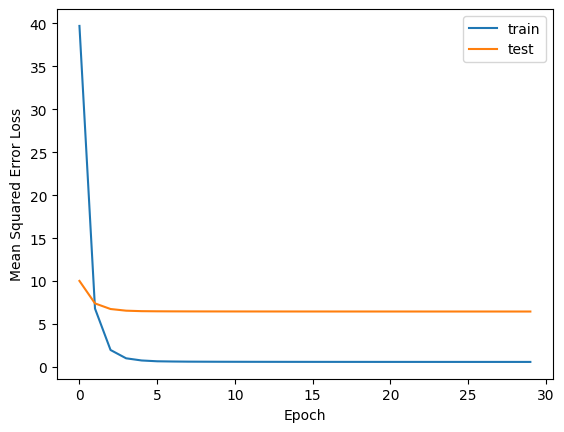

In [5]:
import matplotlib.pyplot as plt
plt.plot(J, label="train")
plt.plot(J_eval, label="test")
plt.legend()
# plt.gca().set_yscale('log')
plt.gca().set_xlabel('Epoch')
plt.gca().set_ylabel('Mean Squared Error Loss')
plt.savefig("als-loss.svg")